In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# loading energy dataset

In [2]:
df_500=pd.read_csv("energy_data_sample.csv")
df_500.head()

,Unnamed: 0,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,0,MAC000002,Std,2012-10-12,0.0
1,1,MAC000002,Std,2012-10-12,0.0
2,2,MAC000002,Std,2012-10-12,0.0
3,3,MAC000002,Std,2012-10-12,0.0
4,4,MAC000002,Std,2012-10-12,0.0


In [3]:
df_500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17311173 entries, 0 to 17311172
Data columns (total 5 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Unnamed: 0               int64  
 1   LCLid                    object 
 2   stdorToU                 object 
 3   DateTime                 object 
 4   KWH/hh (per half hour)   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 660.4+ MB


In [4]:
# Identify the first 500 unique LCLid values
#unique_ids = df['LCLid'].unique()[:500]

# Filter the DataFrame to include only rows with those 500 unique LCLid values
#df_500 = df[df['LCLid'].isin(unique_ids)]

# Display the first few rows of the new DataFrame
#print(df_500.head())

In [5]:
#df_500.to_csv("energy_data_sample.csv")

# data cleaning

# Convert DateTime column to datetime format

In [6]:
# Convert DateTime column to datetime format
df_500['DateTime'] = pd.to_datetime(df_500['DateTime'])

# Extract date only and remove time
df_500['DateTime'] = df_500['DateTime'].dt.date

# replacing string NULLL with nan

In [7]:
df_500['KWH/hh (per half hour) '] = df_500['KWH/hh (per half hour) '].replace('Null', np.nan)
df_500=df_500.dropna(axis=0)
df_500['KWH/hh (per half hour) ']=df_500['KWH/hh (per half hour) '].astype(float)

# calculating total energy consumption per month and dropping energy consumption per hour 

In [8]:
# Add columns for year and month
df_500['YearMonth'] = df_500['DateTime'].apply(lambda x: x.strftime('%Y-%m'))

# Calculate monthly energy consumption for each LCLid
monthly_consumption = df_500.groupby(['LCLid', 'YearMonth'])['KWH/hh (per half hour) '].sum().reset_index()
monthly_consumption.rename(columns={'KWH/hh (per half hour) ': 'MonthlyConsumption'}, inplace=True)

# Add start and end date columns
monthly_consumption['StartDate'] = monthly_consumption['YearMonth'].apply(lambda x: pd.to_datetime(x + '-01'))
monthly_consumption['EndDate'] = monthly_consumption['StartDate'] + pd.offsets.MonthEnd(1)

# Drop the YearMonth column as it's no longer needed
monthly_consumption = monthly_consumption.drop(columns=['YearMonth'])


# creating new features from date time

In [9]:
monthly_consumption['StartDate'] = pd.to_datetime(monthly_consumption['StartDate'])
monthly_consumption['EndDate'] = pd.to_datetime(monthly_consumption['EndDate'])
monthly_consumption['year'] = monthly_consumption['StartDate'].dt.year
monthly_consumption['month'] = monthly_consumption['StartDate'].dt.month
monthly_consumption['quarter'] = monthly_consumption['StartDate'].dt.quarter
monthly_consumption['start_day'] = monthly_consumption['StartDate'].dt.day
monthly_consumption['end_day'] = monthly_consumption['EndDate'].dt.day

In [10]:
monthly_consumption.head()

,LCLid,MonthlyConsumption,StartDate,EndDate,year,month,quarter,start_day,end_day
0,MAC000002,277.746,2012-10-01,2012-10-31,2012,10,4,1,31
1,MAC000002,345.020,2012-11-01,2012-11-30,2012,11,4,1,30
2,MAC000002,355.762,2012-12-01,2012-12-31,2012,12,4,1,31
3,MAC000002,360.082,2013-01-01,2013-01-31,2013,1,1,1,31
4,MAC000002,381.838,2013-02-01,2013-02-28,2013,2,1,1,28


# loading informations_households dataset

In [11]:
household_info=pd.read_csv("informations_households.csv")

In [12]:
household_info.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [13]:
household_info['AcornGroup']=household_info['Acorn'].map({'ACORN-A':' LavishLifestyles', 'ACORN-':'NotPrivateHouseholds', 'ACORN-B':'ExecutiveWealth', 'ACORN-C':'MatureMoney', 'ACORN-D':'CitySophisticates', 'ACORN-E':'CareerClimbers',
       'ACORN-F':'CountrysideCommunities', 'ACORN-G':'SuccessfulSuburbs', 'ACORN-H':'SteadyNeighbourhoods', 'ACORN-I':'ComfortableSeniors', 'ACORN-J':'StartingOut', 'ACORN-K':'StudentLife',
       'ACORN-L':'ModestMeans', 'ACORN-M':'StrivingFamilies', 'ACORN-N':'PoorerPensioners', 'ACORN-O':'YoungHardship', 'ACORN-P':'StrugglingEstates', 'ACORN-Q':'DifficultCircumstances',
       'ACORN-U':'NotPronivateHouseholds'})

# merge energy consumption dataset with households dataset

In [14]:
df_final=monthly_consumption.merge(household_info,on='LCLid',how='left')


In [15]:
df_final=df_final[['LCLid', 'MonthlyConsumption', 'StartDate', 'EndDate', 'year', 'month',
       'quarter', 'start_day', 'end_day', 'AcornGroup']]
df_final.head()

,LCLid,MonthlyConsumption,StartDate,EndDate,year,month,quarter,start_day,end_day,AcornGroup
0,MAC000002,277.746,2012-10-01,2012-10-31,2012,10,4,1,31,LavishLifestyles
1,MAC000002,345.020,2012-11-01,2012-11-30,2012,11,4,1,30,LavishLifestyles
2,MAC000002,355.762,2012-12-01,2012-12-31,2012,12,4,1,31,LavishLifestyles
3,MAC000002,360.082,2013-01-01,2013-01-31,2013,1,1,1,31,LavishLifestyles
4,MAC000002,381.838,2013-02-01,2013-02-28,2013,2,1,1,28,LavishLifestyles


# exploratory data analysis

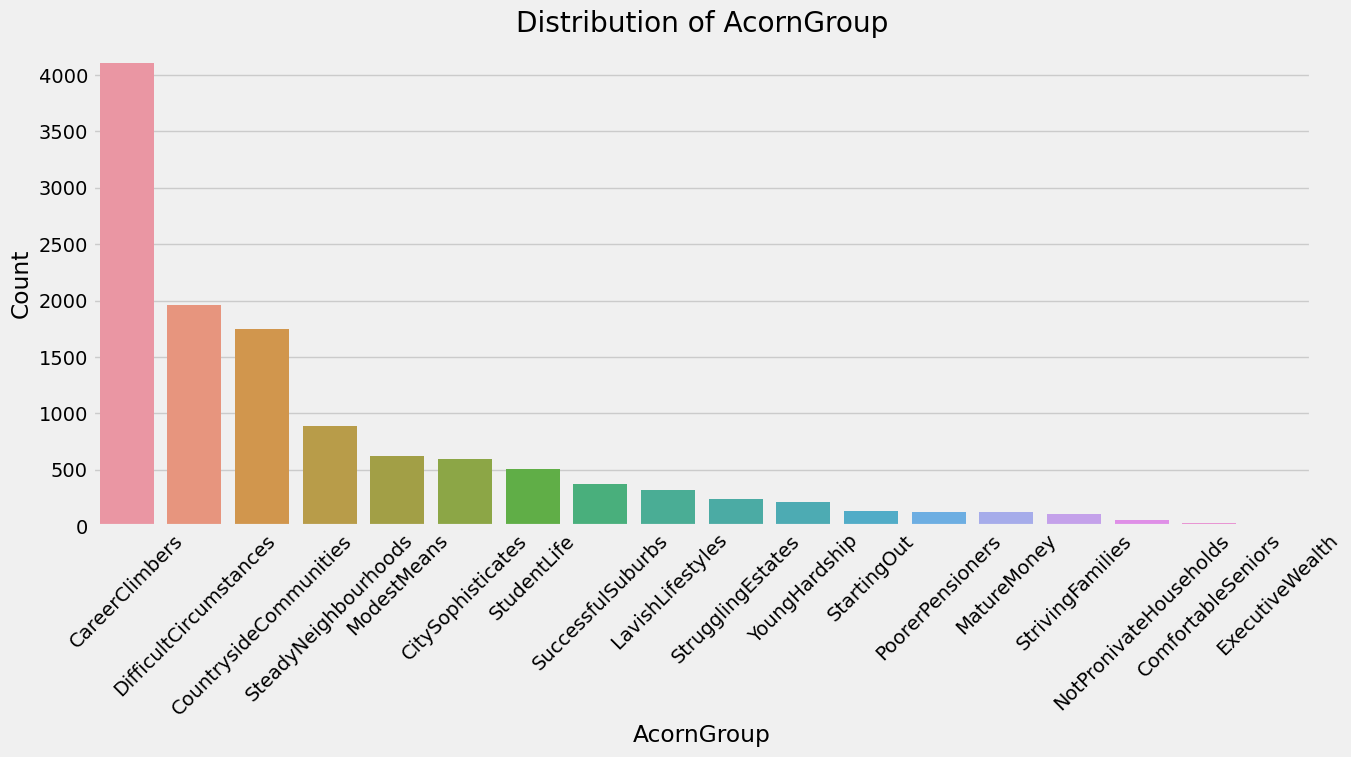

In [16]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_final, x='AcornGroup', order=df_final['AcornGroup'].value_counts().index)
plt.title('Distribution of AcornGroup')
plt.xlabel('AcornGroup')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

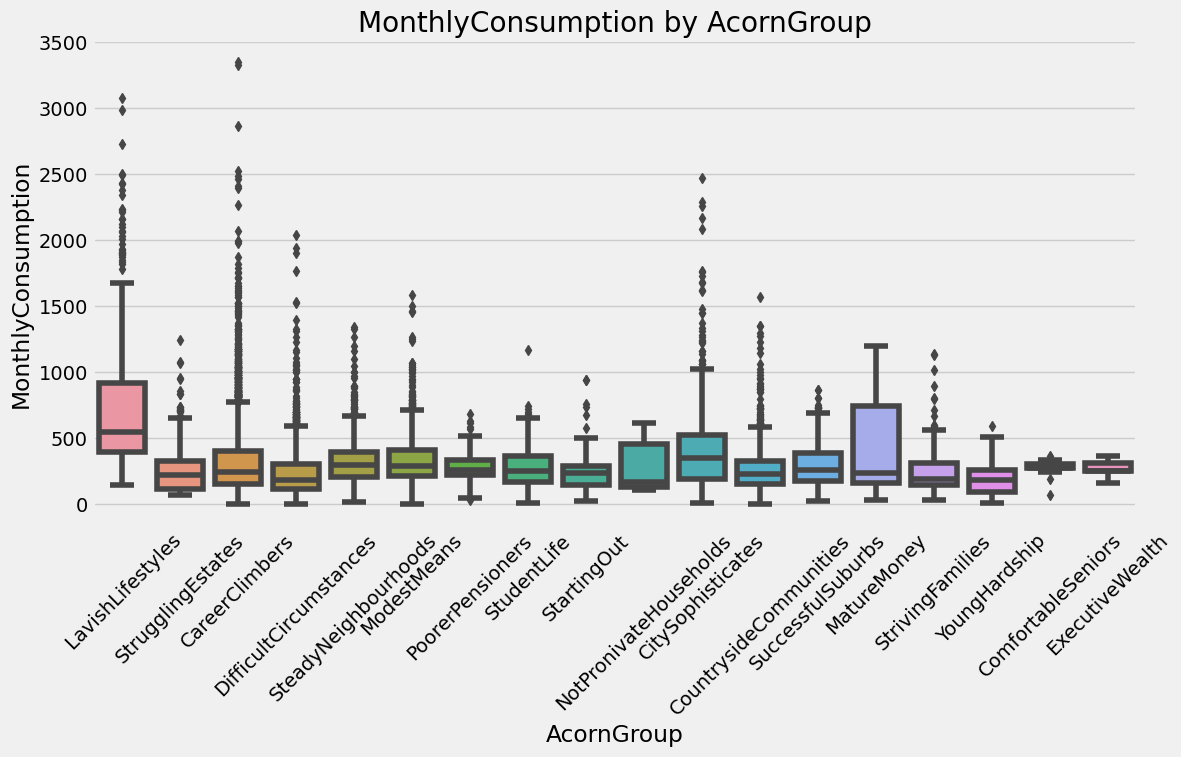

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_final, x='AcornGroup', y='MonthlyConsumption')
plt.title('MonthlyConsumption by AcornGroup')
plt.xlabel('AcornGroup')
plt.ylabel('MonthlyConsumption')
plt.xticks(rotation=45)
plt.show()

In [18]:


# Calculate descriptive statistics
grouped_stats = df_final.groupby('AcornGroup')['MonthlyConsumption'].agg(['mean', 'median', 'std','min','max', 'count']).reset_index()

# Print the table
print(grouped_stats)


                AcornGroup        mean    median         std      min  \
0         LavishLifestyles  760.249474  544.5530  564.459472  145.131   
1           CareerClimbers  327.787679  243.9560  292.684682    0.047   
2        CitySophisticates  424.849432  348.6610  347.707472    5.759   
3       ComfortableSeniors  278.441333  277.4015   57.026829   65.695   
4   CountrysideCommunities  255.594599  226.4280  166.056686    0.000   
5   DifficultCircumstances  244.163003  179.9395  200.896795    0.211   
6          ExecutiveWealth  265.964273  248.8700   62.117778  158.850   
7              MatureMoney  407.708000  235.7765  319.923385   32.872   
8              ModestMeans  352.976822  290.0840  226.443738    0.000   
9   NotPronivateHouseholds  281.850444  166.6255  170.306471  104.892   
10        PoorerPensioners  278.135472  255.6200  114.105756   33.463   
11             StartingOut  249.714053  238.0470  153.737484   22.773   
12    SteadyNeighbourhoods  325.832359  299.9100  1

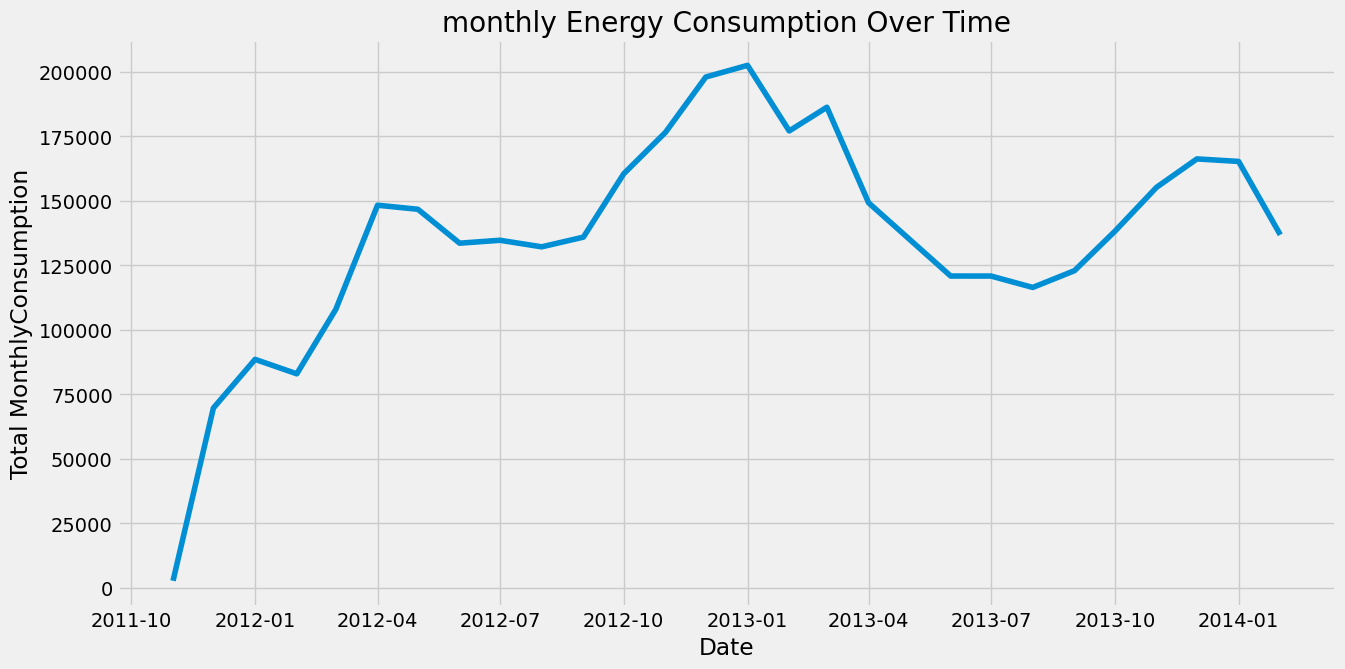

In [19]:
monthly_consumption = df_final.groupby('StartDate')['MonthlyConsumption'].sum().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(monthly_consumption['StartDate'], monthly_consumption['MonthlyConsumption'])
plt.title('monthly Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Total MonthlyConsumption')
plt.show()

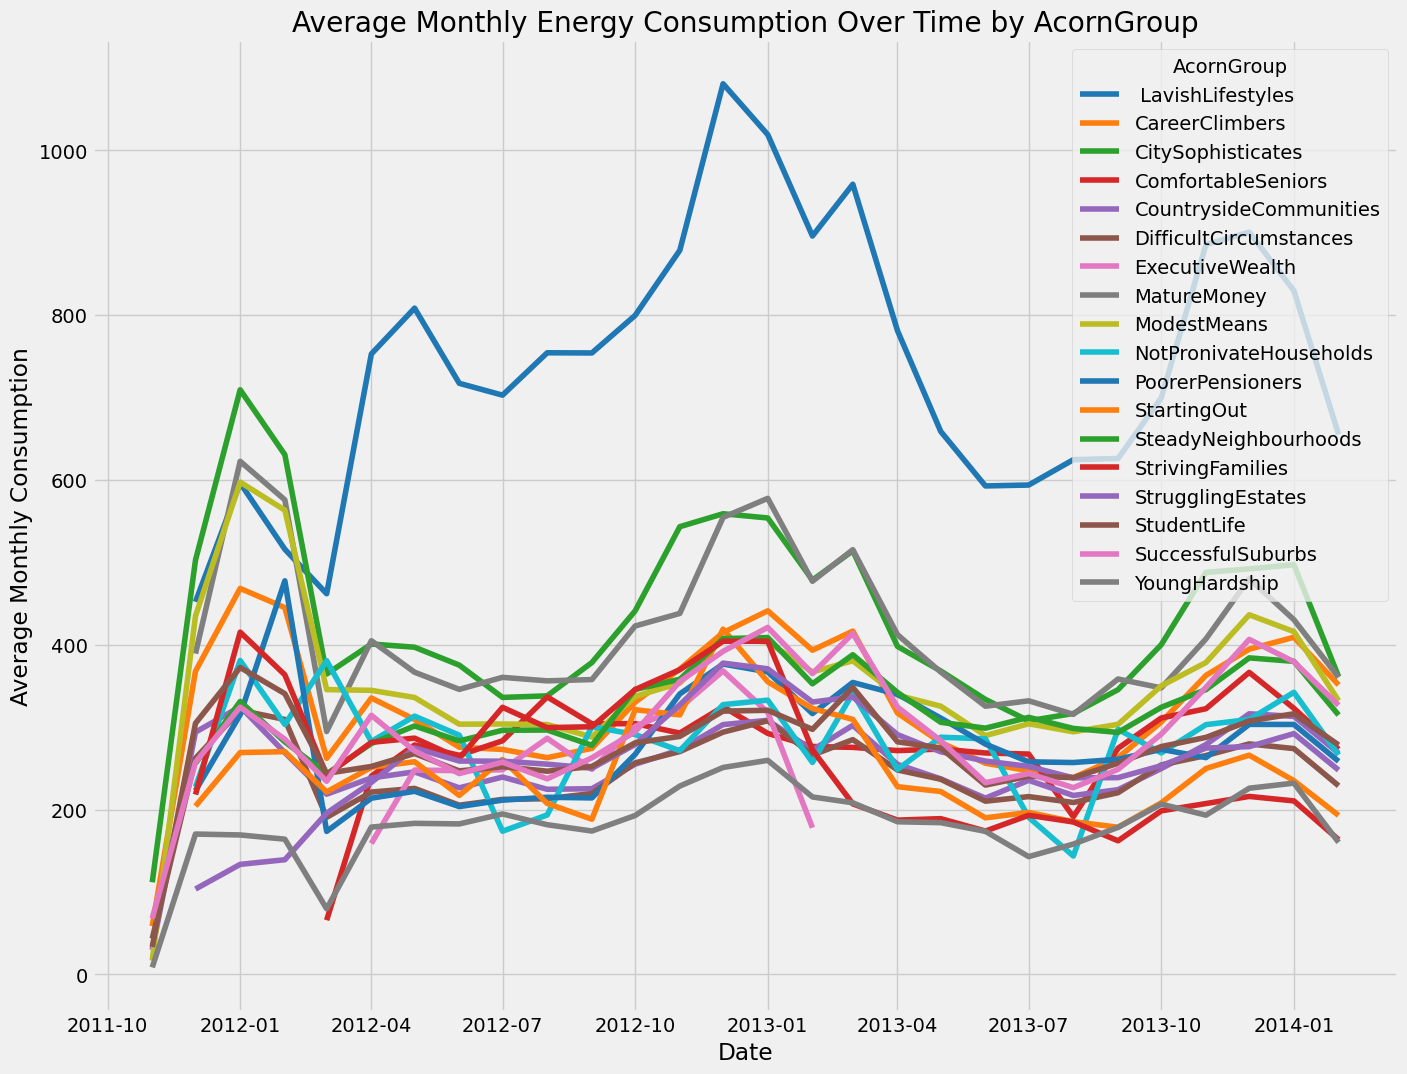

In [20]:


# Aggregate data by date and AcornGroup
grouped_data = df_final.groupby(['StartDate', 'AcornGroup'])['MonthlyConsumption'].mean().reset_index()

# Pivot the data to have StartDate as index and AcornGroup as columns
pivot_data = grouped_data.pivot(index='StartDate', columns='AcornGroup', values='MonthlyConsumption')

# Plotting
plt.figure(figsize=(15, 12))

# Choose a color palette
palette = sns.color_palette("tab10", len(pivot_data.columns))

# Plot each AcornGroup with a different color
for i, group in enumerate(pivot_data.columns):
    plt.plot(pivot_data.index, pivot_data[group], label=group, color=palette[i])

plt.title('Average Monthly Energy Consumption Over Time by AcornGroup')
plt.xlabel('Date')
plt.ylabel('Average Monthly Consumption')
plt.legend(title='AcornGroup')
plt.show()



       MonthlyConsumption            StartDate              EndDate  \
count           27.000000                   27                   27   
mean           203.683593  2012-12-31 04:26:40  2013-01-29 14:13:20   
min             83.559000  2011-12-01 00:00:00  2011-12-31 00:00:00   
25%            142.064500  2012-06-16 00:00:00  2012-07-15 12:00:00   
50%            210.394000  2013-01-01 00:00:00  2013-01-31 00:00:00   
75%            266.450000  2013-07-16 12:00:00  2013-08-15 12:00:00   
max            293.559000  2014-02-01 00:00:00  2014-02-28 00:00:00   
std             66.276882                  NaN                  NaN   

              year      month    quarter  start_day    end_day  
count    27.000000  27.000000  27.000000       27.0  27.000000  
mean   2012.555556   6.333333   2.444444        1.0  30.407407  
min    2011.000000   1.000000   1.000000        1.0  28.000000  
25%    2012.000000   3.000000   1.000000        1.0  30.000000  
50%    2013.000000   6.000000   2.0

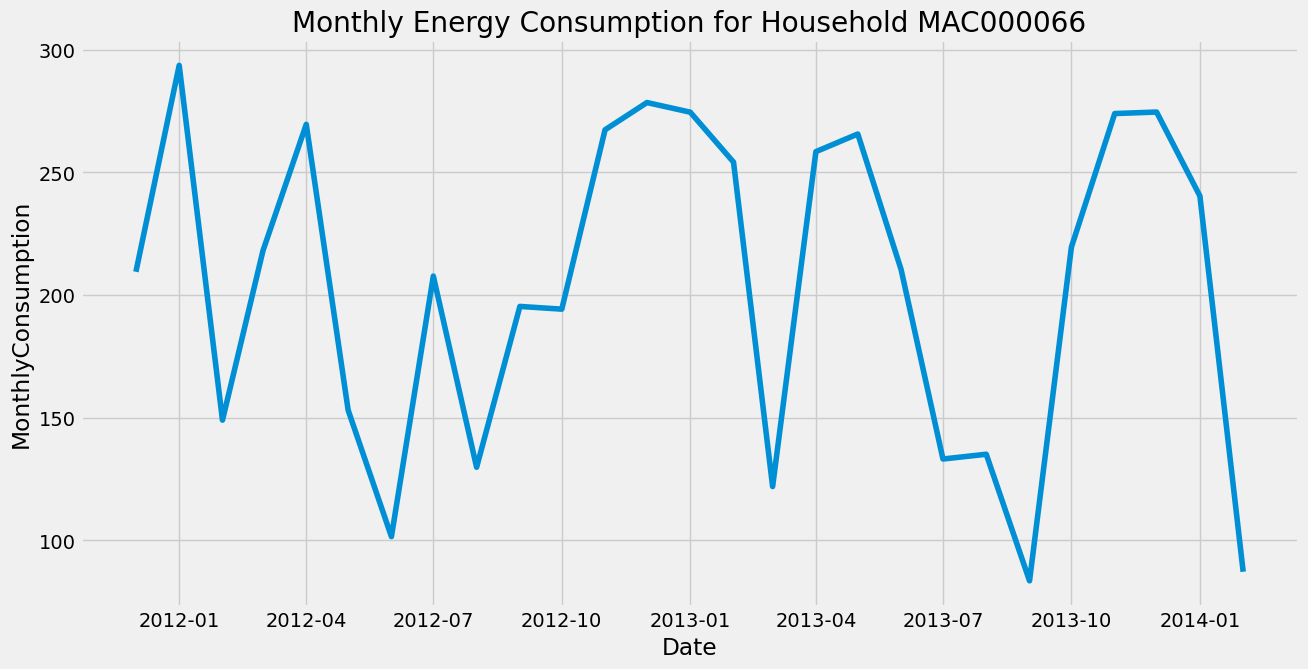

In [21]:
household_id = 'MAC000066'
household_data = df_final[df_final['LCLid'] == household_id]

# Basic statistics for the household
print(household_data.describe())

# Time series plot for the household
plt.figure(figsize=(14, 7))
plt.plot(household_data['StartDate'], household_data['MonthlyConsumption'])
plt.title(f'Monthly Energy Consumption for Household {household_id}')
plt.xlabel('Date')
plt.ylabel('MonthlyConsumption')
plt.show()

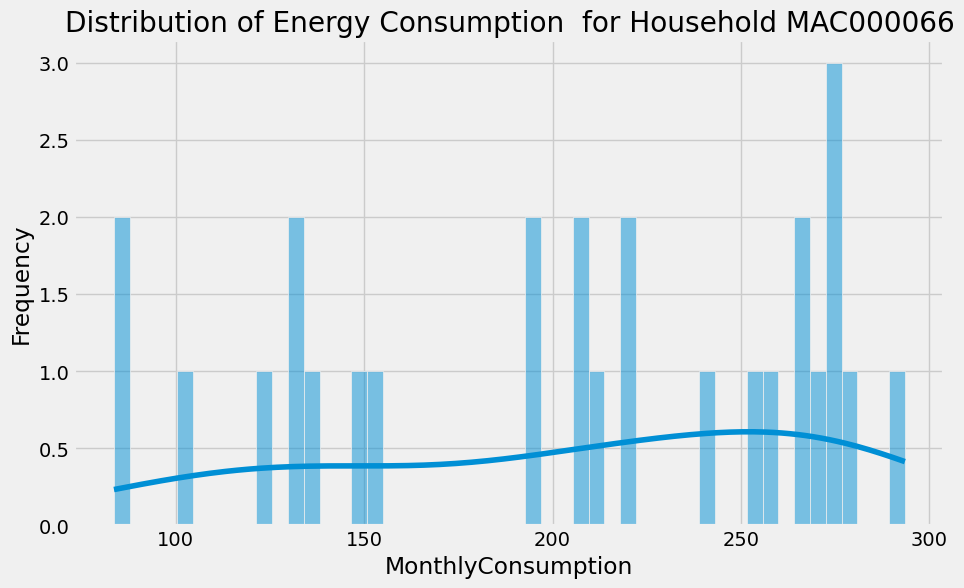

In [22]:
# Distribution of KW_per_day
plt.figure(figsize=(10, 6))
sns.histplot(household_data['MonthlyConsumption'], bins=50, kde=True)
plt.title('Distribution of Energy Consumption  for Household MAC000066')
plt.xlabel('MonthlyConsumption')
plt.ylabel('Frequency')
plt.show()


# feature engineering: 
Create the new feature for previous month's energy consumption for each household


In [23]:
# Sort the dataframe by LCLid and StartDate to ensure the shift operation is correct
df_final = df_final.sort_values(by=['LCLid', 'StartDate'])

# Create the new feature for previous month's energy consumption
df_final['PrevMonthConsumption'] = df_final.groupby('LCLid')['MonthlyConsumption'].shift(1)
df_final['PrevMonthConsumption'].fillna(0, inplace=True)
df_final.head()

,LCLid,MonthlyConsumption,StartDate,EndDate,year,month,quarter,start_day,end_day,AcornGroup,PrevMonthConsumption
0,MAC000002,277.746,2012-10-01,2012-10-31,2012,10,4,1,31,LavishLifestyles,0.000
1,MAC000002,345.020,2012-11-01,2012-11-30,2012,11,4,1,30,LavishLifestyles,277.746
2,MAC000002,355.762,2012-12-01,2012-12-31,2012,12,4,1,31,LavishLifestyles,345.020
3,MAC000002,360.082,2013-01-01,2013-01-31,2013,1,1,1,31,LavishLifestyles,355.762
4,MAC000002,381.838,2013-02-01,2013-02-28,2013,2,1,1,28,LavishLifestyles,360.082


# data preprocessing

In [24]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to the 'original_language' column and transform it
df_final['AcornGroup'] = label_encoder.fit_transform(df_final['AcornGroup'])
print(df_final.head())

       LCLid  MonthlyConsumption  StartDate    EndDate  year  month  quarter  \
0  MAC000002             277.746 2012-10-01 2012-10-31  2012     10        4   
1  MAC000002             345.020 2012-11-01 2012-11-30  2012     11        4   
2  MAC000002             355.762 2012-12-01 2012-12-31  2012     12        4   
3  MAC000002             360.082 2013-01-01 2013-01-31  2013      1        1   
4  MAC000002             381.838 2013-02-01 2013-02-28  2013      2        1   

   start_day  end_day  AcornGroup  PrevMonthConsumption  
0          1       31           0                 0.000  
1          1       30           0               277.746  
2          1       31           0               345.020  
3          1       31           0               355.762  
4          1       28           0               360.082  


In [25]:
# Splitting data into X and y
X = df_final.drop(["LCLid",'StartDate','EndDate','MonthlyConsumption'], axis=1)
y = df_final["MonthlyConsumption"]


In [26]:
X.columns=X.columns.astype(str)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [28]:

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train = scaler.fit_transform(X_train)

# Transform the testing data
X_test = scaler.transform(X_test)

# X_train_scaled and X_test_scaled are now standardized


In [29]:
def print_evaluate(true, predicted):
    # Mean Absolute Error
    mae = metrics.mean_absolute_error(true, predicted)
    # Mean Squarred Error
    mse = metrics.mean_squared_error(true, predicted)
    # Calculating R2 Score
    r2_score = metrics.r2_score(true, predicted)
    # Calculating RMSE Score
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))

    # Calculating mean_absolute_percentage_error
    mape = metrics.mean_absolute_percentage_error(true, predicted)

    print('Mean Absolute Error', mae)
    print('Mean Squarred Error', mse)
    print('Root Mean Squarred Error', rmse)
    print('mean_absolute_percentage_error', mape)
    print('R2 Score:', r2_score)

def evaluate(true, predicted):

    # Calculating MAE Score
    mae = metrics.mean_absolute_error(true, predicted)
    # Calculatinog MSE Score
    mse = metrics.mean_squared_error(true, predicted)
    # Calculationg R2 Score
    r2_score = metrics.r2_score(true, predicted)
    # Calculating RMSE Score
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))

    mape = metrics.mean_absolute_percentage_error(true, predicted)
    # Return ing Score
    return mae, mse, rmse,mape ,r2_score

# models with default parameters

In [30]:
def train_models(X_train, y_train, X_test, y_test):
    results_df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'R2 Score'])

    # Models to be trained
    models = {
        'LinearRegression': LinearRegression(),
        'DecisionTreeRegressor': DecisionTreeRegressor(random_state=1000),
        'GradientBoostingRegressor': GradientBoostingRegressor(random_state=1000),
        'RandomForestRegressor': RandomForestRegressor(random_state=1000),
        'KNeighborsRegressor': KNeighborsRegressor(),
        'BaggingRegressor': BaggingRegressor(random_state=1000)
    }

    for i, (name, model) in enumerate(models.items()):
        print(f"Training and evaluating {name}...\n{'_'*40}")

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        test_pred = model.predict(X_test)
        train_pred = model.predict(X_train)

        # Evaluation
        print(f'Test set evaluation for {name}:\n{"_"*40}')
        print_evaluate(y_test, test_pred)
        print(f'Train set evaluation for {name}:\n{"_"*40}')
        print_evaluate(y_train, train_pred)
        results_df.loc[i] = [name, *evaluate(y_test, test_pred)]

    # Plot results
    print('====================================')
    print('Test set results for all models')
    plt.figure(figsize=(18, 18))
    for i, (name, model) in enumerate(models.items()):
        plt.subplot(3, 2, i + 1)
        plt.scatter(y_test, model.predict(X_test))
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(name)
    plt.show()

    return results_df

Training and evaluating LinearRegression...
________________________________________
Test set evaluation for LinearRegression:
________________________________________
Mean Absolute Error 61.789950491781475
Mean Squarred Error 12409.415474672134
Root Mean Squarred Error 111.39755596363923
mean_absolute_percentage_error 187845144554705.75
R2 Score: 0.8251081428515151
Train set evaluation for LinearRegression:
________________________________________
Mean Absolute Error 60.889335656457206
Mean Squarred Error 12917.453398170419
Root Mean Squarred Error 113.6549752460068
mean_absolute_percentage_error 117775998590374.88
R2 Score: 0.8201577647911708
Training and evaluating DecisionTreeRegressor...
________________________________________
Test set evaluation for DecisionTreeRegressor:
________________________________________
Mean Absolute Error 76.70376227894424
Mean Squarred Error 20453.40329806079
Root Mean Squarred Error 143.01539531833905
mean_absolute_percentage_error 229370239177154.16

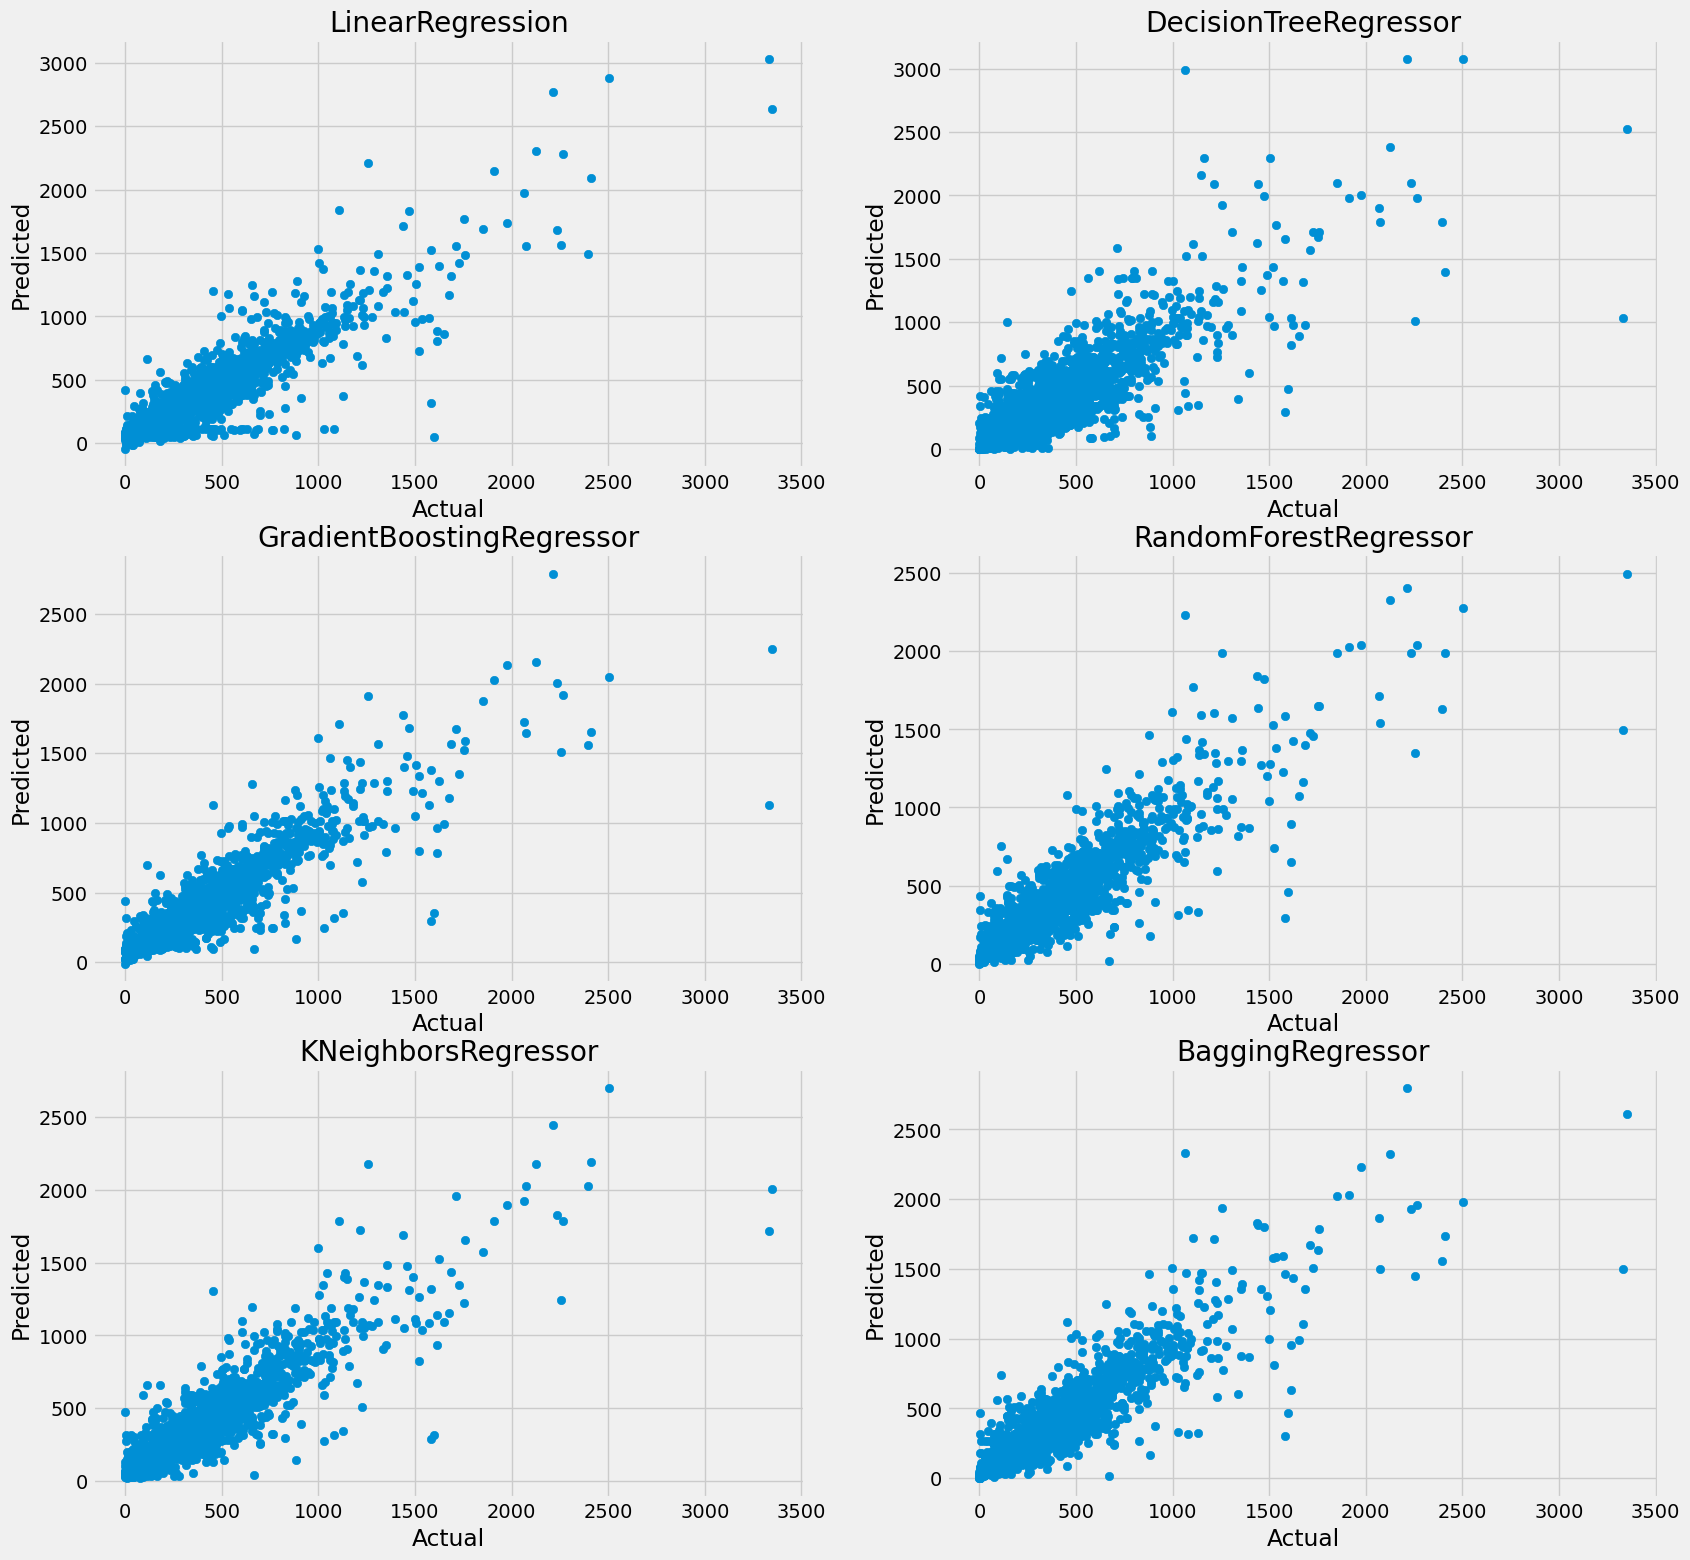

In [31]:
results = train_models(X_train, y_train, X_test, y_test)

In [32]:
results

,Model,MAE,MSE,RMSE,MAPE,R2 Score
0,LinearRegression,61.789950,12409.415475,111.397556,1.878451e+14,0.825108
1,DecisionTreeRegressor,76.703762,20453.403298,143.015395,2.293702e+14,0.711740
2,GradientBoostingRegressor,51.990713,11165.212985,105.665571,2.422527e+14,0.842643
3,RandomForestRegressor,57.642894,12129.944844,110.136029,5.042596e+13,0.829047
4,KNeighborsRegressor,57.682459,11707.653850,108.201912,2.347301e+14,0.834998
5,BaggingRegressor,60.176932,12848.430866,113.350919,3.678127e+13,0.818921


# hyperparameter optimization of all models using GridSearchCV

In [33]:

from sklearn.model_selection import GridSearchCV



def train_models(X_train, y_train, X_test, y_test):
    results_df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'R2 Score'])

    # Models and their parameter grids
    models = {
        'LinearRegression': (LinearRegression(), {}),
        'DecisionTreeRegressor': (DecisionTreeRegressor(random_state=1000), {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 10, 20]
        }),
        'GradientBoostingRegressor': (GradientBoostingRegressor(random_state=1000), {
            'n_estimators': [100, 200,500],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }),
        'RandomForestRegressor': (RandomForestRegressor(random_state=1000), {
            'n_estimators': [100, 200,500],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 10, 20]
        }),
        'KNeighborsRegressor': (KNeighborsRegressor(), {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }),
        'BaggingRegressor': (BaggingRegressor(random_state=1000), {
            'n_estimators': [10, 50, 100,200,500],
            'max_samples': [0.5, 1.0],
            'max_features': [0.5, 1.0]
        })
    }

    for i, (name, (model, param_grid)) in enumerate(models.items()):
        print(f"Training and evaluating {name}...\n{'_'*40}")

        # GridSearchCV
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Train the model with the best parameters
        best_model.fit(X_train, y_train)

        # Predictions
        test_pred = best_model.predict(X_test)
        train_pred = best_model.predict(X_train)

        # Evaluation
        print(f'Test set evaluation for {name}:\n{"_"*40}')
        print_evaluate(y_test, test_pred)
        print(f'Train set evaluation for {name}:\n{"_"*40}')
        print_evaluate(y_train, train_pred)
        results_df.loc[i] = [name, *evaluate(y_test, test_pred)]

    # Plot results
    print('====================================')
    print('Test set results for all models')
    plt.figure(figsize=(18, 18))
    for i, (name, (model, _)) in enumerate(models.items()):
        plt.subplot(3, 2, i + 1)
        plt.scatter(y_test, best_model.predict(X_test))
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(name)
    plt.show()

    return results_df

Training and evaluating LinearRegression...
________________________________________
Test set evaluation for LinearRegression:
________________________________________
Mean Absolute Error 61.789950491781475
Mean Squarred Error 12409.415474672134
Root Mean Squarred Error 111.39755596363923
mean_absolute_percentage_error 187845144554705.75
R2 Score: 0.8251081428515151
Train set evaluation for LinearRegression:
________________________________________
Mean Absolute Error 60.889335656457206
Mean Squarred Error 12917.453398170419
Root Mean Squarred Error 113.6549752460068
mean_absolute_percentage_error 117775998590374.88
R2 Score: 0.8201577647911708
Training and evaluating DecisionTreeRegressor...
________________________________________
Test set evaluation for DecisionTreeRegressor:
________________________________________
Mean Absolute Error 58.59493212595624
Mean Squarred Error 13825.666599196686
Root Mean Squarred Error 117.58259479700507
mean_absolute_percentage_error 78087582946778.6


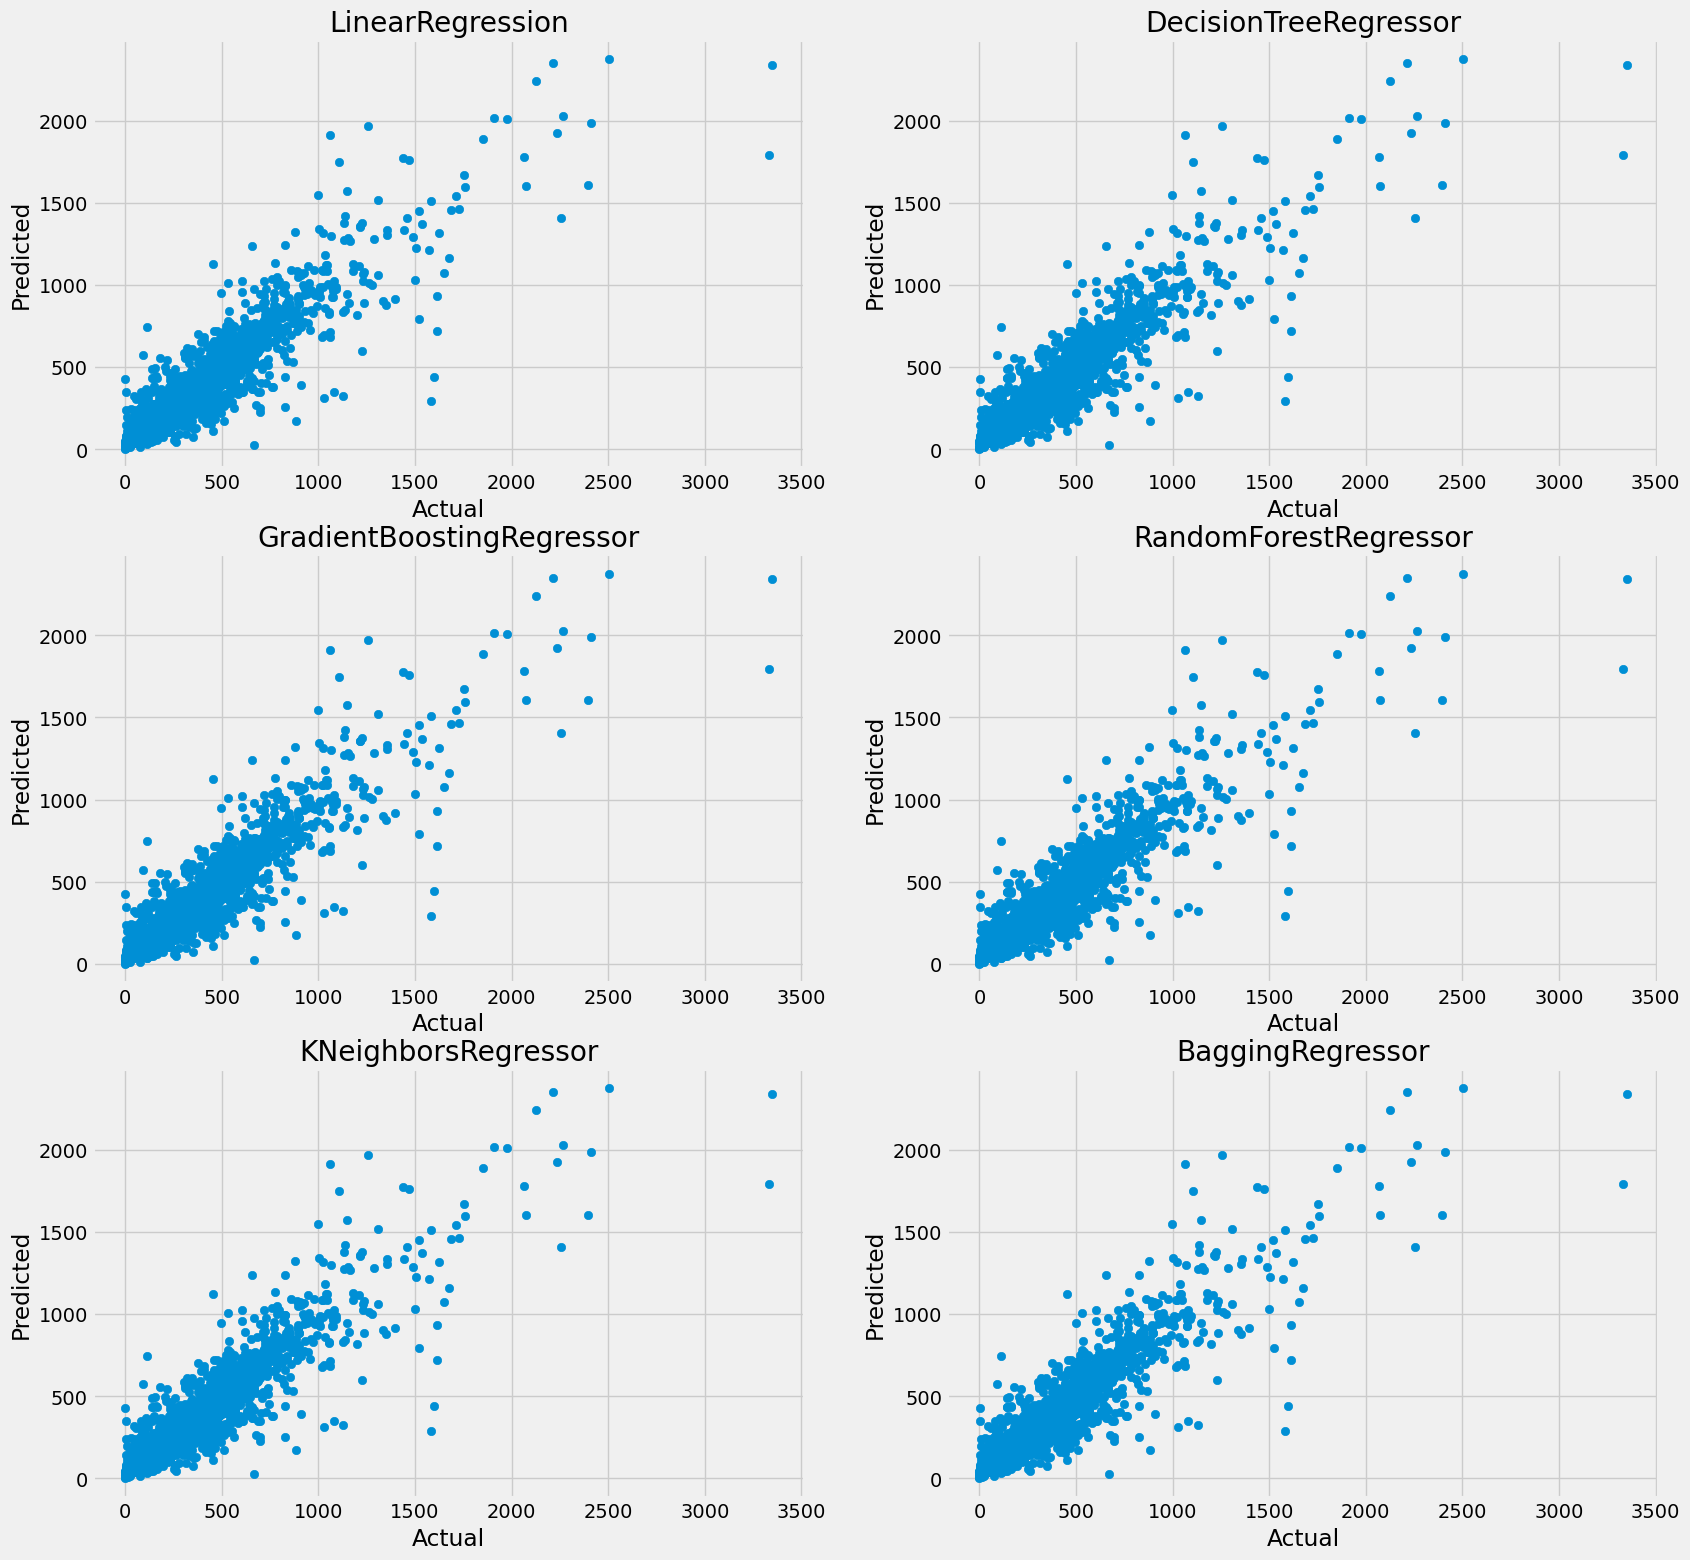

In [34]:
results = train_models(X_train, y_train, X_test, y_test)

In [35]:
results

,Model,MAE,MSE,RMSE,MAPE,R2 Score
0,LinearRegression,61.789950,12409.415475,111.397556,1.878451e+14,0.825108
1,DecisionTreeRegressor,58.594932,13825.666599,117.582595,7.808758e+13,0.805148
2,GradientBoostingRegressor,51.990713,11165.212985,105.665571,2.422527e+14,0.842643
3,RandomForestRegressor,52.415094,10671.867742,103.304732,7.404837e+13,0.849596
4,KNeighborsRegressor,56.073012,10922.979000,104.513057,2.583377e+14,0.846057
5,BaggingRegressor,54.258555,10854.766125,104.186209,8.135693e+13,0.847019
